This workbook is the Python implementation of exact STP EI gradients w.r.t. input vector **x** (i.e. STP dEI).

The synthetic (test) function is: *y* = sin(**x**).

STP EI is the Expected Improvement with Student's-t Processes' acquisition function for Bayesian optimization (i.e. BayesOpt).

Requires: 'pyGPGO', a Python (>3.5) package for BayesOpt.

https://pygpgo.readthedocs.io/en/latest/

In [1]:
pip install pyGPGO


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
### 1. Import python modules/packages required:

import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
import warnings
import itertools
import seaborn as sns
import time

from pyGPGO.GPGO import GPGO
from pyGPGO.surrogates.tStudentProcess import tStudentProcess
from pyGPGO.acquisition import Acquisition
from pyGPGO.covfunc import squaredExponential
from joblib import Parallel, delayed
from scipy.linalg import inv
from scipy.spatial.distance import cdist
from scipy.optimize import minimize
from scipy.stats import t
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset

warnings.filterwarnings("ignore", category=RuntimeWarning)


In [3]:
### 2. Assign user-defined input variables:

n_start_AcqFunc = 25                            # Multiple random-starts to avoid local optima in STP EI optimization

n_test = 250                                    # number of prediction observations
eps = 1e-08                                     # numerical stability constant

util_grad_exact = 'dEI_STP'                      # STP EI acquisition function, optimized using exact STP EI gradients
util_grad_approx = 'tExpectedImprovement'        # STP EI acquisition function, optimized using approx STP EI gradients

n_init = 2                                      # number of random initialisation iterations
iters = 1                                       # number of post-initialisation iterations (will increase incrementally)
opt = True                                      # Hyperparameter-tuning implemented for S.E. kernel parameters x3

df = 3                                          # nu paramater for STP


In [4]:
### 3. Synthetic function for testing i.e. y = sine(x):

def objfunc(x1_training):                       # Define synthetic function
        return  operator * np.sin(x1_training)
                          
def objfunc_der(x1_training):                   # Define synthetic function's true first-order derivative i.e. gradient
        return  operator * np.cos(x1_training)

# Constraints:
lb = 0                                          # Lower-bound of synthetic function's input x vector (1-D)
ub = 2 * np.pi                                  # Upper-bound of synthetic function's input x vector (1-D)
    
# Input array dimension(s):                     # 1-D problem
dim = 1

# 1-D inputs' parameter bounds:                 # 1-D bounds' parameter object
param = {'x1_training': ('cont', [lb, ub])}

# True y bounds:
operator = 1                                  # Can toggle between seeking the synthetic's minimum versus maximum
y_global_orig = 1                             # Maximum for y = sine(x)

# Test data:
x1_test = np.linspace(lb, ub, n_test)         # Define test data object
x_test = np.column_stack((x1_test)).T         # Transposed for algebraic reasons

seed = 1                                      # Re-producability term for randomized initialization
cov_func = squaredExponential()               # S.E. kernel class


In [5]:
### 4. Squared-exponential (S.E.) kernel: definition and exact first-order kernel derivative terms

def kronDelta(X, Xstar):                     # Kronecker's Delta method
    return cdist(X, Xstar) < np.finfo(np.float32).eps

def se(X, Xstar, sigmaf, l, sigman):         # S.E. kernel method
    return sigmaf * np.exp(-0.5 * cdist(X, Xstar) ** 2 / l ** 2) + sigman * kronDelta(X, Xstar)

def delta(X, Xstar):                         # Distance between training X and test Xstar vectors
    return (X - Xstar)
   
def der_covmat(X, Xstar, sigmaf, l, sigman): # Covariance matrix derivative terms (i.e. exact, first-order)
    nx = len(X)
    ny = len(Xstar)
    return np.round(np.array([(delta(np.atleast_2d(i), np.atleast_2d(j))[0] * se(np.atleast_2d(i), np.atleast_2d(j), sigmaf, l, sigman)[0]).sum() for (i, j) in itertools.product(X, Xstar)]).reshape(nx, ny), 8)


In [6]:
### 5. Update Student's-t Process (GP) surrogate class, to reflect the S.E. kernel's exact, first-order derivatives:

class dtStudentProcess(tStudentProcess):    # Via inheritance, also optimises hyperparameters when opt = TRUE
    
    def AcqGrad(self, Xstar):               # Method returning exact, first-order derivatives of the STP's posterior mean and standard deviation
        Xstar = np.atleast_2d(Xstar)
        Kstar = self.covfunc.K(self.X, Xstar).T
        dKstar = der_covmat(self.X, Xstar, self.covfunc.sigmaf, self.covfunc.l, self.covfunc.sigman).T
        
        smd_adj = (self.nu + self.beta1 - 2) / (self.nu + self.n1 - 2)

        alpha = np.dot(np.linalg.inv(self.K11 + (self.covfunc.sigman**2) * np.eye(len(self.X))), self.y)
        alpha_Kstar = np.dot(np.linalg.inv(self.K11 + (self.covfunc.sigman**2) * np.eye(len(self.X))), Kstar.T)      
        
        dm = np.dot(dKstar, alpha)
        ds = -2 * smd_adj * np.dot(dKstar, alpha_Kstar)
        
        return dm, ds                     


In [7]:
### 6. Update Acquisition Function class, to reflect STP EI's exact, first-order derivative terms:

class Acquisition_new(Acquisition):        # Via inheritance
    def __init__(self, mode, eps=eps, **params):
        
        self.params = params
        self.eps = eps

        mode_dict = {
            'dEI_STP': self.dEI_STP
        }

        self.f = mode_dict[mode]
    
    def dEI_STP(self, tau, mean, std, ds, dm, nu=3.0): # STP EI acquisition function, also returns exact STP EI derivative for each input-dimension
        gamma = (mean - tau - self.eps) / (std + self.eps)
        gamma_h = (mean - tau) / (std + self.eps)
        dsdx = ds / (2 * (std + self.eps))
        dmdx = (dm - gamma * dsdx) / (std + self.eps)
        
        f = (std + self.eps) * (gamma * t.cdf(gamma, df=nu) + (nu + gamma ** 2)/(nu - 1) * t.pdf(gamma, df=nu))
        df1 = f / (std + self.eps) * dsdx 
        df2 = (std + self.eps) * (t.cdf(gamma, df=nu) * dmdx + gamma * t.pdf(gamma, df=nu) \
            * (1 - (nu + gamma ** 2)/(nu - 1) + 2/(nu - 1) * dmdx))
        df = df1 + df2

        df_arr = []

        for j in range(0, dim):
          df_arr.append([df])
        return f, np.asarray(df_arr).transpose()

    def d_eval(self, tau, mean, std, ds, dm, nu=3.0): # Wrapper function to evaluate dEI_GP
    
        return self.f(tau, mean, std, ds, dm, nu=3.0, **self.params)


In [8]:
### 7. Update Bayesian optimisation classes, to reflect: STP EI's exact derivative, variable multi-starts and start_point_arr attributes:

class dGPGO(GPGO):
    eps = eps

    def acqfunc(self, xnew, n_start=n_start_AcqFunc):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        dm, ds = self.GP.AcqGrad(xnew)
        f, df = self.A.d_eval(self.tau, new_mean, new_std, ds=ds, dm=dm, nu=3.0)
        
        return -f, -df                      # Returns both STP EI and exact STP EI derivative i.e. STP dEI

    def d_optimizeAcq(self, method='L-BFGS-B', n_start=n_start_AcqFunc):
        start_points_dict = [self._sampleParam() for i in range(n_start)]
        start_points_arr = np.array([list(s.values())
                                     for s in start_points_dict])
        x_best = np.empty((n_start, len(self.parameter_key)))
        f_best = np.empty((n_start,))
        opt = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.acqfunc,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = True, # Requires STP dEI returned as an attribute by self.acqfunc
                                                                 bounds=self.parameter_range) for start_point in
                                               start_points_arr)
        x_best = np.array([res.x for res in opt])
        f_best = np.array([np.atleast_1d(res.fun)[0] for res in opt])

        self.x_best = x_best
        self.f_best = f_best
        self.best = x_best[np.argmin(f_best)]
        self.start_points_arr = start_points_arr

        return x_best, f_best, start_points_arr
    
    def run(self, max_iter=10, init_evals=3, resume=False):
        
        if not resume:
            self.init_evals = init_evals
            self._firstRun(self.init_evals)
            self.logger._printInit(self)
        for iteration in range(max_iter):
            self.d_optimizeAcq()            # Requires exact GP EI derivatives returned as an attribute by self.acqfunc
            self.updateGP()
            self.logger._printCurrent(self)

class GPGO_multi(GPGO):

    def _optimizeAcq(self, method='L-BFGS-B', n_start=n_start_AcqFunc):
        
        start_points_dict = [self._sampleParam() for i in range(n_start)]
        start_points_arr = np.array([list(s.values())
                                     for s in start_points_dict])
        x_best = np.empty((n_start, len(self.parameter_key)))
        f_best = np.empty((n_start,))
        opt = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self._acqWrapper,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 bounds=self.parameter_range) for start_point in
                                               start_points_arr)
        x_best = np.array([res.x for res in opt])
        f_best = np.array([np.atleast_1d(res.fun)[0] for res in opt])

        self.x_best = x_best
        self.f_best = f_best
        self.best = x_best[np.argmin(f_best)]
        self.start_points_arr = start_points_arr

        return x_best, f_best, start_points_arr
          
    def run(self, max_iter=10, init_evals=3, resume=False):
        
        if not resume:
            self.init_evals = init_evals
            self._firstRun(self.init_evals)
            self.logger._printInit(self)
        for iteration in range(max_iter):
            self._optimizeAcq()            
            self.updateGP()
            self.logger._printCurrent(self)


In [9]:
### 8. Plot synthetic function: plus approximate versus exact gradients for y = sine(x):

def plot_sineApproxGrad(gpgo, param, new=True):
    x_test = np.linspace(lb, ub, n_test).reshape((n_test, 1))
    x_test_h = x_test + eps
    y_hat, y_var = gpgo.GP.predict(x_test, return_std=True)
    std = np.sqrt(y_var)
    l, u = y_hat - 3.182 * std, y_hat + 3.182 * std
    colours = ['Post', 'Random']
    if new:
        plt.figure(figsize=[7,5])
        plt.scatter(gpgo.GP.X, gpgo.GP.y, marker ='D', color = 'Red', label='Post-initialisation point: ($\mathbf{x}$, $y$)')
        plt.scatter(gpgo.X, gpgo.y, marker ='D', color = 'Green', label='Random-initialisation point: ($\mathbf{x}$, $y$)')
        grad = np.array([gpgo.GP.predict(np.atleast_1d(x))[0] for x in x_test]).flatten()
        grad_h = np.array([gpgo.GP.predict(np.atleast_1d(x))[0] for x in x_test_h]).flatten()
        grad = np.array((grad_h - grad)/eps).flatten()
        plt.ylim(-3, 6)
        plt.xlim(0,2 * np.pi)
        plt.plot(x_test.flatten(), operator * objfunc(x_test.flatten()), color = 'Yellow', label='Objective function: $y$ = sin($\mathbf{x}$)')
        plt.plot(x_test.flatten(), y_hat, color = 'Orange', ls = '--', label='STP Posterior mean: $\hat{y} = \mu_{STP}(\mathbf{x})$')
        plt.plot(x_test.flatten(), operator * objfunc_der(x_test.flatten()), color = 'Blue', label='Objective gradient: d$y$/d$\mathbf{x}$ = cos($\mathbf{x}$)')
        plt.plot(x_test, grad, color='Purple', ls = '--', label='STP Posterior mean gradient: d$\hat{y}$/d$\mathbf{x}$ = d$\mu_{STP}(\mathbf{x})$/d$\mathbf{x}$')    
        plt.fill_between(x_test.flatten(), l, u, alpha=0.2, label='95% Confidence Interval for $\mu_{STP}(\mathbf{x})$')
        title = 'Sine, STP EI optimised with approximate STP EI gradients'
        plt.title(title, weight = 'bold')
        plt.xlabel("$\mathbf{x}$")
        plt.ylabel("sin($\mathbf{x}$), cos($\mathbf{x}$), $\hat{y}$, d$\hat{y}$/d$\mathbf{x}$")
        plt.legend(loc=9)
        plt.show()

def plot_sineExactGrad(dgpgo, param, new=True):
    x_test = np.linspace(lb, ub, n_test).reshape((n_test, 1))
    y_hat, y_var = dgpgo.GP.predict(x_test, return_std=True)
    std = np.sqrt(y_var)
    l, u = y_hat - 3.182 * std, y_hat + 3.182 * std
    colours = ['Post', 'Random']
    if new:
        plt.figure(figsize=[7,5])
        plt.scatter(dgpgo.GP.X, dgpgo.GP.y, marker ='D', color = 'Red', label='Post-initialisation point: ($\mathbf{x}$, $y$)')
        plt.scatter(dgpgo.X, dgpgo.y, marker ='D', color = 'Green', label='Random-initialisation point: ($\mathbf{x}$, $y$)')
        grad = np.array([dgpgo.GP.AcqGrad(np.atleast_1d(x))[0] for x in x_test]).flatten()
        plt.ylim(-3, 6)
        plt.xlim(0,2 * np.pi)
        plt.plot(x_test.flatten(), operator * objfunc(x_test.flatten()), color = 'Yellow', label='Objective function: $y$ = sin($\mathbf{x}$)')
        plt.plot(x_test.flatten(), y_hat, color = 'Orange', ls = '--', label='STP Posterior mean: $\hat{y} = \mu_{STP}(\mathbf{x})$')
        plt.plot(x_test.flatten(), operator * objfunc_der(x_test.flatten()), color = 'Blue', label='Objective gradient: d$y$/d$\mathbf{x}$ = cos($\mathbf{x}$)')
        plt.plot(x_test, grad, color='Purple', ls = '--', label='STP Posterior mean gradient: d$\hat{y}$/d$\mathbf{x}$ = d$\mu_{STP}(\mathbf{x})$/d$\mathbf{x}$')
        plt.fill_between(x_test.flatten(), l, u, alpha=0.2, label='95% Confidence Interval for $\mu_{STP}(\mathbf{x})$')
        title = 'Sine, STP EI optimised with exact STP EI gradients'
        plt.title(title, weight = 'bold')
        plt.xlabel("$\mathbf{x}$")
        plt.ylabel("sin($\mathbf{x}$), cos($\mathbf{x}$), $\hat{y}$, d$\hat{y}$/d$\mathbf{x}$")
        plt.legend(loc=9)
        plt.show()


In [10]:
### 9. Combined STP EI acquisition function plots: approximate versus exact STP EI gradients impacting next x (zoomed)

def plot_STP_EI_exactApproxAcqFunc(gpgo, dgpgo, param, new):
    fig, ax = plt.subplots(figsize=[7,5])    
    x_test = np.linspace(lb, ub, n_test).reshape((n_test, 1))
    a_exact = np.array([-dgpgo.acqfunc(np.atleast_1d(x))[0] for x in x_test]).flatten()
    a_approx = np.array([-gpgo._acqWrapper(np.atleast_1d(x))[0] for x in x_test]).flatten()
    plt.plot(x_test, a_exact, color='Red', label='STP EI$(\mathbf{x})$')
    plt.ylim(min(a_exact), max(a_exact) + 0.01)
    plt.xlim(0, 2 * np.pi)
    plt.axvline(x=x_test[np.argmax(a_exact)], color='Blue', ls = '--', label='STP EI arg max $\mathbf{x}$: Exact STP EI gradients')
    ###plt.axvline(x=x_test[np.argmax(a_approx)], color='Green', ls = '--', label='STP EI arg max $\mathbf{x}$: Approx STP EI gradients')
    plt.axvline(x=1.55, color='Green', ls = '--', label='STP EI arg max $\mathbf{x}$: Approx STP EI gradients')
    plt.axhline(y=max(a_exact), color='Yellow', ls = '-', label='$y$ = Maximum STP EI$(\mathbf{x})$')
    plt.legend(loc=1)
    plt.xlabel("$\mathbf{x}$")
    plt.ylabel("STP EI$(\mathbf{x})$")
    title = 'STP EI, optimised with exact STP EI gradients'
    plt.suptitle(title, weight = 'bold')

    axins = inset_axes(ax, 2, 2, loc=7, bbox_to_anchor=(0.9, 0.45),bbox_transform=ax.figure.transFigure)
    axins.plot(x_test[0:], a_exact[0:], color='r', label='STP EI$(\mathbf{x})$')
    #####plt.scatter(x_test[np.argmax(a_exact)], max(a_exact), marker="D", color='Blue')    
    axins.set_ylim(0.135, 0.14125)
    axins.set_xlim(0, 1.95) # Limit the region for zoom
    plt.xlabel("$\mathbf{x}$")
    plt.ylabel("STP EI$(\mathbf{x})$")
    axins.set_autoscaley_on(True)
    plt.axvline(x_test[np.argmax(a_exact)][0], color='Blue', ls = '--', label='STP EI arg max $\mathbf{x}$: Exact STP EI gradients')
    ###plt.axvline(x_test[np.argmax(a_approx)][0], color='Green', ls = '--', label='STP EI arg max $\mathbf{x}$: Approx STP EI gradients')
    plt.axvline(1.55, color='Green', ls = '--', label='STP EI arg max $\mathbf{x}$: Approx STP EI gradients')
    plt.axhline(y=max(a_exact), color='Yellow', ls = '-', label='$y$ = Maximum STP EI$(\mathbf{x})$')
    mark_inset(ax, axins, loc1=3, loc2=4, fc="none", ec="0.9")
    plt.draw()
    plt.show()


In [11]:
### 10. Add the respective approximate and exact STP EI gradients to the STP EI plots:

def plot_STP_EI_approxShowGrads(gpgo, param, new):
    fig, ax = plt.subplots(figsize=[7,5])
    x_test = np.linspace(lb, ub, n_test).reshape((n_test, 1))
    x_test_h = x_test + eps
    a = np.array([-gpgo._acqWrapper(np.atleast_1d(x))[0] for x in x_test]).flatten()
    a_h = np.array([-gpgo._acqWrapper(np.atleast_1d(x))[0] for x in x_test_h]).flatten()
    a_grad = np.array((a_h - a)/eps).flatten()
    plt.plot(x_test, a, color='Purple', label='STP EI$(\mathbf{x})$')
    plt.plot(x_test, a_grad, color='Green', ls = '-', label='Approximate STP EI$(\mathbf{x})$ gradients')
    plt.ylim(-0.05 + min(min(a_grad), min(a)), max(max(a_grad), max(a)) + 0.05)
    plt.xlim(0, 2 * np.pi)
    plt.axvline(x=x_test[np.argmax(a)], color='Brown', ls = '--', label='STP EI: arg max $\mathbf{x}$')
    plt.legend(loc=4)
    plt.xlabel("$\mathbf{x}$")
    plt.ylabel("STP EI$(\mathbf{x})$, Approximate STP EI$(\mathbf{x})$ gradients")
    title = 'STP EI, optimised with approximate STP EI gradients'
    plt.suptitle(title, weight = 'bold')
    plt.draw()
    plt.show()
    print('Approx STP EI gradients: STP EI Maximum   ', np.round(max(a), 4))
    print('', )
    print('Approx STP EI gradients: Maximum gradient', np.round(max(a_grad), 4))
    print('Approx STP EI gradients: Minimum gradient', np.round(min(a_grad), 4))
    
def plot_STP_EI_exactShowGrads(gpgo, param, new):
    fig, ax = plt.subplots(figsize=[7,5])
    x_test = np.linspace(lb, ub, n_test).reshape((n_test, 1))
    a = np.array([-gpgo.acqfunc(np.atleast_1d(x))[0] for x in x_test]).flatten()
    a_grad = np.array([-gpgo.acqfunc(np.atleast_1d(x))[1] for x in x_test]).flatten()
    plt.plot(x_test, a, color='Red', label='STP EI$(\mathbf{x})$')
    plt.plot(x_test, a_grad, color='Blue', ls = '-', label='Exact STP EI$(\mathbf{x})$ gradients')
    plt.ylim(-0.05 + min(min(a_grad), min(a)), max(max(a_grad), max(a)) + 0.05)
    plt.xlim(0, 2 * np.pi)
    plt.axvline(x=x_test[np.argmax(a)], color='Brown', ls = '--', label='STP EI: arg max $\mathbf{x}$')
    plt.legend(loc=4)
    plt.xlabel("$\mathbf{x}$")
    plt.ylabel("STP EI$(\mathbf{x})$, Exact STP EI$(\mathbf{x})$ gradients")
    title = 'STP EI, optimised with exact STP EI gradients'
    plt.suptitle(title, weight = 'bold')
    plt.draw()
    plt.show()
    print('Exact STP EI gradients: STP EI Maximum   ', np.round(max(a), 4))
    print('', )
    print('Exact STP EI gradients: Maximum gradient', np.round(max(a_grad), 4))
    print('Exact STP EI gradients: Minimum gradient', np.round(min(a_grad), 4))
    

In [12]:
### 11. Approximate versus exact STP EI gradients: Post-initialization iteration 1

np.random.seed(seed)
surrogate_approx_1 = tStudentProcess(cov_func, optimize=opt, nu = df)
approx_1 = GPGO_multi(surrogate_approx_1, Acquisition(util_grad_approx), objfunc, param)
approx_1.run(init_evals=n_init, max_iter=iters)

np.random.seed(seed)
surrogate_exact_1 = dtStudentProcess(cov_func, optimize=opt, nu = df)
exact_1 = dGPGO(surrogate_exact_1, Acquisition_new(util_grad_exact), objfunc, param)
exact_1.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [2.62022653]. 	  0.4980652197092493 	 0.4980652197092493
init   	 [4.52593227]. 	  -0.9826672516685445 	 0.4980652197092493
1      	 [2.62022576]. 	  0.49806588758991555 	 0.49806588758991555
Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [2.62022653]. 	  0.4980652197092493 	 0.4980652197092493
init   	 [4.52593227]. 	  -0.9826672516685445 	 0.4980652197092493
1      	 [2.64589724]. 	  0.4756434766468938 	 0.4980652197092493


In [13]:
### 12. Approximate versus exact STP EI gradients: Post-initialization iteration 2

np.random.seed(seed)
surrogate_approx_2 = tStudentProcess(cov_func, optimize=opt, nu = df)
approx_2 = GPGO_multi(surrogate_approx_2, Acquisition(util_grad_approx), objfunc, param)
approx_2.run(init_evals=n_init, max_iter=iters+1)

np.random.seed(seed)
surrogate_exact_2 = dtStudentProcess(cov_func, optimize=opt, nu = df)
exact_2 = dGPGO(surrogate_exact_2, Acquisition_new(util_grad_exact), objfunc, param)
exact_2.run(init_evals=n_init, max_iter=iters+1)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [2.62022653]. 	  0.4980652197092493 	 0.4980652197092493
init   	 [4.52593227]. 	  -0.9826672516685445 	 0.4980652197092493
1      	 [2.62022576]. 	  0.49806588758991555 	 0.49806588758991555
2      	 [2.39361815]. 	  0.6801553320295219 	 0.6801553320295219
Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [2.62022653]. 	  0.4980652197092493 	 0.4980652197092493
init   	 [4.52593227]. 	  -0.9826672516685445 	 0.4980652197092493
1      	 [2.64589724]. 	  0.4756434766468938 	 0.4980652197092493
2      	 [1.56113012]. 	  0.9999532825986917 	 0.9999532825986917


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [2.62022653]. 	  0.4980652197092493 	 0.4980652197092493
init   	 [4.52593227]. 	  -0.9826672516685445 	 0.4980652197092493
1      	 [2.62022576]. 	  0.49806588758991555 	 0.49806588758991555
2      	 [2.39361815]. 	  0.6801553320295219 	 0.6801553320295219
3      	 [1.89031388]. 	  0.9493870677938372 	 0.9493870677938372


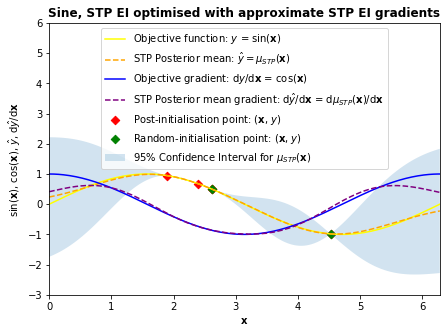

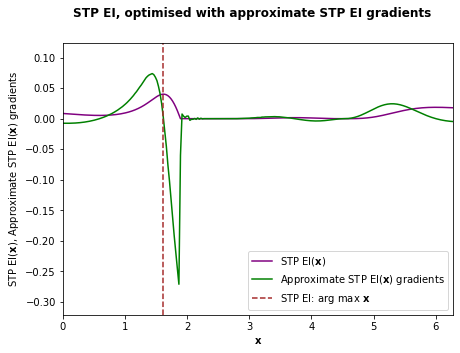

Approx STP EI gradients: STP EI Maximum    0.0401

Approx STP EI gradients: Maximum gradient 0.0738
Approx STP EI gradients: Minimum gradient -0.2708


In [14]:
### 13. Approximate versus exact STP EI gradients: Post-initialization iteration 3

np.random.seed(seed)
surrogate_approx_3 = tStudentProcess(cov_func, optimize=opt, nu = df)
approx_3 = GPGO_multi(surrogate_approx_3, Acquisition(util_grad_approx), objfunc, param)
approx_3.run(init_evals=n_init, max_iter=iters+2)

plot_sineApproxGrad(approx_3, param, new=True)
plot_STP_EI_approxShowGrads(approx_3, param, new=True)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [2.62022653]. 	  0.4980652197092493 	 0.4980652197092493
init   	 [4.52593227]. 	  -0.9826672516685445 	 0.4980652197092493
1      	 [2.64589724]. 	  0.4756434766468938 	 0.4980652197092493
2      	 [1.56113012]. 	  0.9999532825986917 	 0.9999532825986917
3      	 [0.0994078]. 	  0.09924415830062683 	 0.9999532825986917


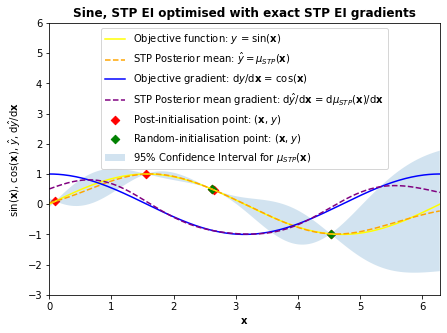

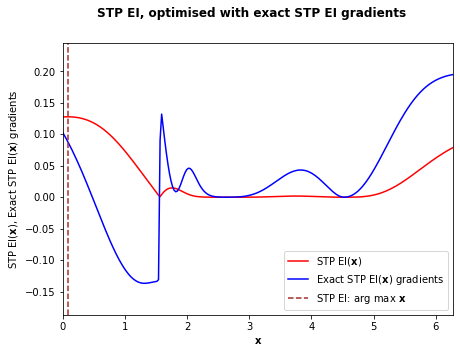

Exact STP EI gradients: STP EI Maximum    0.1278

Exact STP EI gradients: Maximum gradient 0.195
Exact STP EI gradients: Minimum gradient -0.1368


In [15]:
### 14. Approximate versus exact STP EI gradients: Post-initialization iteration 3

np.random.seed(seed)
surrogate_exact_3 = dtStudentProcess(cov_func, optimize=opt, nu = df)
exact_3 = dGPGO(surrogate_exact_3, Acquisition_new(util_grad_exact), objfunc, param)
exact_3.run(init_evals=n_init, max_iter=iters+2)

plot_sineExactGrad(exact_3, param, new=True)
plot_STP_EI_exactShowGrads(exact_2, param, new=True)


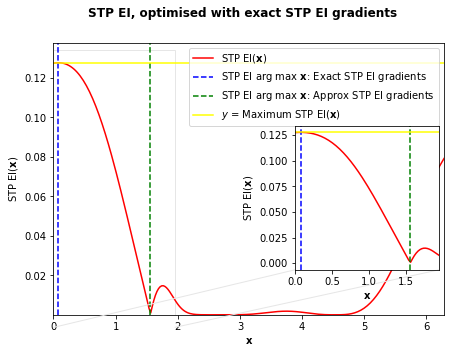

In [16]:
### 15. Combined STP EI plot: approximate versus exact STP EI gradients, compared for x sampling (zoomed)

plot_STP_EI_exactApproxAcqFunc(approx_2, exact_2, param, new=True)
